In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from somJ.som import SoM
import somJ.config as config
from experimentos.functions import *

2025-05-15 20:56:56.194882: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 20:56:56.195362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:56:56.197517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:56:56.203850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747339016.214714  216355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747339016.21

In [2]:
def nodes_to_images(nodes):
    """Converts an m x n x 784 array to m x n x 28 x 28 uint8 images scaled to [0,255]."""
    m, n, dim = nodes.shape
    assert dim == 784, f"Expected last dimension 784, got {dim}"
    images = np.zeros((m, n, 28, 28), dtype=np.uint8)
    for i in range(m):
        for j in range(n):
            v = nodes[i, j].astype(np.float32)
            v_min, v_max = v.min(), v.max()
            if v_max > v_min:
                scaled = (v - v_min) / (v_max - v_min) * 255.0
            else:
                scaled = np.zeros_like(v)
            images[i, j] = scaled.reshape(28, 28).astype(np.uint8)
    return images


In [3]:
def create_image_grid(images):
    """Stitches m x n x 28 x 28 images into a single (m*28) x (n*28) image."""
    m, n, h, w = images.shape
    grid = np.zeros((m * h, n * w), dtype=np.uint8)
    for i in range(m):
        for j in range(n):
            grid[i*h:(i+1)*h, j*w:(j+1)*w] = images[i, j]
    return grid


In [ ]:
def create_label_map_image(neuron_labels, m, n, cell_size=28, colormap=None):
    """
    Creates an RGB image of shape (m*cell_size, n*cell_size, 3) where each cell is colored by its label.
    neuron_labels: dict mapping (i,j) -> label int
    m, n: grid dimensions
    cell_size: pixel size of each cell
    """
    labels = sorted(set(neuron_labels.values()))
    if colormap is None:
        cmap = plt.get_cmap('tab10', len(labels))
        colormap = {lbl: tuple((np.array(cmap(idx)[:3]) * 255).astype(np.uint8))
                    for idx, lbl in enumerate(labels)}
    grid_img = np.zeros((m*cell_size, n*cell_size, 3), dtype=np.uint8)
    for (i, j), lbl in neuron_labels.items():
        color = colormap.get(lbl, (0, 0, 0))
        grid_img[i*cell_size:(i+1)*cell_size,
                 j*cell_size:(j+1)*cell_size] = color
    return grid_img

In [5]:
from sklearn.preprocessing import MinMaxScaler
X,y= load_dataset("MNIST")


In [6]:
som = SoM(
    method="pca",
    data=X,
    total_nodes=config.TOTAL_NODES
)
som.train(
    train_data=X,
    learn_rate=config.LEARNING_RATE,
    radius_sq=config.RADIUS_SQ,
    lr_decay=config.LR_DECAY,
    radius_decay=config.RADIUS_DECAY,
    epochs=config.EPOCHS,
    update="batchmap",
    batch_size=config.BATCH_SIZE,
    step=config.STEP,
    save=config.SAVE_HISTORY,
    prog_bar=True
)

Entrenando SOM: 100%|█████████████████████| 50/50 [06:43<00:00,  8.07s/it, lr=0.00863, radius=0.294]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from somJ.som import SoM
import somJ.config as config
from experimentos.functions import load_dataset


/tmp/ipykernel_216355/254837260.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # dejar espacio para la leyenda


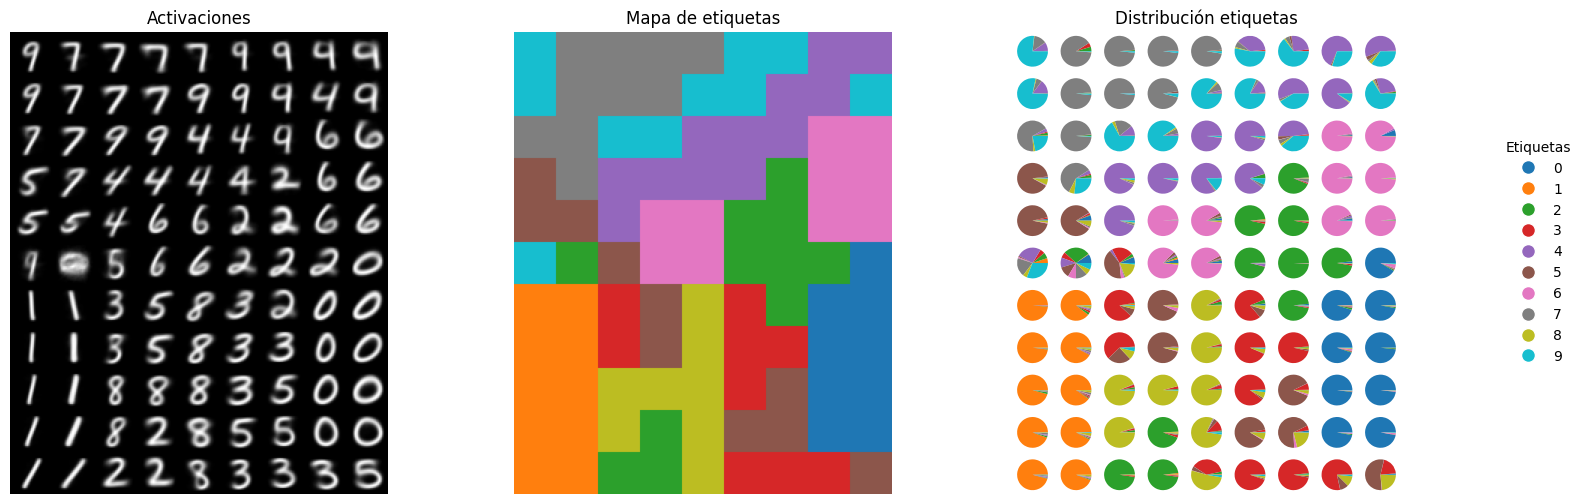

In [ ]:
m, n = som.grid_size
weights = som.re_scale()
nodes = weights.reshape(m, n, -1)

# Activaciones como imagen
imgs = nodes_to_images(nodes)
grid = create_image_grid(imgs)

# Escalamos las muestras para asignar buscar la distancia respeto al mapa escalado
X_scaled=som.scaler.fit_transform(X)
# Mapa de etiquetas
label_map = {}
for sample, label in zip(X_scaled, y):
    coord = som.find_winner(sample)
    label_map.setdefault(coord, []).append(label)
neuron_labels = {coord: max(lbls, key=lbls.count)
                    for coord, lbls in label_map.items()}
label_img = create_label_map_image(neuron_labels, m, n)

# Distribución de etiquetas por neurona
label_names = np.unique(y)

# Figuras combinadas: tres en fila, mismas proporciones
fig = plt.figure(figsize=(18, 6))
outer = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.3)

# Activaciones
ax0 = fig.add_subplot(outer[0])
ax0.imshow(grid, cmap='gray')
ax0.set_title('Activaciones')
ax0.axis('off')

#  Mapa de etiquetas
ax1 = fig.add_subplot(outer[1])
ax1.imshow(label_img)
ax1.set_title('Mapa de etiquetas')
ax1.axis('off')

# Grid de pie charts (sin inversión de eje y)
inner = gridspec.GridSpecFromSubplotSpec(m, n, subplot_spec=outer[2], wspace=0.1, hspace=0.1)
for (i, j), lbls in label_map.items():
    ax = fig.add_subplot(inner[i, j], aspect=1)
    fracs = [lbls.count(l) for l in label_names]
    ax.pie(fracs, colors=plt.cm.tab10.colors, radius=1)
    ax.set_xticks([])
    ax.set_yticks([])

# Título general para la tercera columna
ax2 = fig.add_subplot(outer[2])
ax2.set_title('Distribución etiquetas')
ax2.axis('off')

# Añadir leyenda vertical al lado derecho
# Crear manejadores para cada etiqueta y color
from matplotlib.lines import Line2D
colors = plt.cm.tab10.colors
legend_handles = [Line2D([0], [0], marker='o', color='w', label=str(label),
                            markerfacecolor=colors[idx % len(colors)], markersize=10)
                    for idx, label in enumerate(label_names)]
# Posicionar la leyenda fuera del gráfico principal
fig.legend(handles=legend_handles,
            loc='center right',
            title='Etiquetas',
            frameon=False)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # dejar espacio para la leyenda
plt.savefig('img/mnist_visualización.png', dpi=300)
plt.show()
